## The Data

** Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line **

**Monthly milk production: pounds per cow. Jan 62 - Dec 75**

** Import numpy pandas and matplotlib **

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

** Use pandas to read the csv of the monthly-milk-production.csv file and set index_col='Month' **

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
milk = pd.read_csv("gdrive/My Drive/dataML/monthly-milk-production.csv",index_col='Month')

#milk = pd.read_csv("monthly-milk-production.csv",index_col='Month')

In [0]:
milk.head()

Milk Production
Month                               
1962-01-01 01:00:00            589.0
1962-02-01 01:00:00            561.0
1962-03-01 01:00:00            640.0
1962-04-01 01:00:00            656.0
1962-05-01 01:00:00            727.0

** Check out the head of the dataframe**

** Make the index a time series by using: **

    milk.index = pd.to_datetime(milk.index)

In [0]:
milk.index = pd.to_datetime(milk.index)

In [0]:
milk.head()

Milk Production
Month                               
1962-01-01 01:00:00            589.0
1962-02-01 01:00:00            561.0
1962-03-01 01:00:00            640.0
1962-04-01 01:00:00            656.0
1962-05-01 01:00:00            727.0

In [0]:
milk.keys()

Index(['Milk Production'], dtype='object')

** Plot out the time series data. **

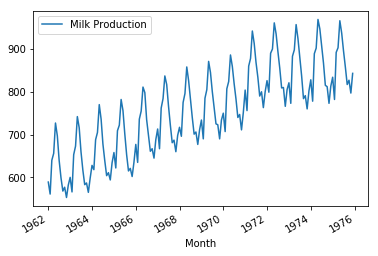

In [0]:
milk.plot()

### Train Test Split

** Let's attempt to predict a year's worth of data. (12 months or 12 steps into the future) **


In [0]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [0]:
len(milk)

168

In [0]:
train_set= milk.head((1976-1962-1)*12)

In [0]:
test_set = milk.tail(12)

### Scale the Data

** Use sklearn.preprocessing to scale the data using the MinMaxScaler. Remember to only fit_transform on the training data, then transform the test data. You shouldn't fit on the test data as well, otherwise you are assuming you would know about future behavior!**

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()

In [0]:
train_scaled = scaler.fit_transform(train_set)

In [0]:
test_scaled = scaler.transform(test_set)

## Build Training Data(many to many)

* X_train: Past 12 monthes productions, shape: (-1,12)
* Y_train: Future 12 month productions, shape:(-1, 12) 
* Shift the window to get more trainning data

In [0]:
def build_train_data(data, past_monthes = 12, future_monthes = 12):
  X_train, Y_train = [],[]
  
  for i in range(data.shape[0] + 1 - past_monthes - future_monthes):
    X_train.append(np.array(data[i:i + past_monthes]))
    Y_train.append(np.array(data[i + past_monthes:i + past_monthes + future_monthes]))
    
  return np.array(X_train).reshape([-1,12]), np.array(Y_train).reshape([-1,12])
   

In [0]:
x, y = build_train_data(train_scaled)

In [0]:
print('x shape;', x.shape, 'y shape: ', y.shape)

x shape; (132, 12) y shape:  (132, 12)


Take a look at the data

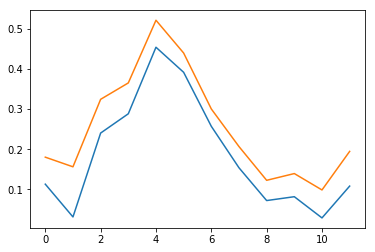

In [0]:
plt.plot(x[12])
plt.plot(y[12])

## Keras

In [0]:
from tensorflow.keras import layers, Sequential,models

In [0]:
RNN_CELLSIZE = 10
SEQLEN = 12
BATCHSIZE = 10

### Build and Train the Model
Many to Many

In [0]:
model_layers = [
    layers.Reshape((SEQLEN,1),input_shape=(SEQLEN,)),
    layers.GRU(RNN_CELLSIZE, return_sequences=True),
    layers.GRU(RNN_CELLSIZE, return_sequences=True),
    layers.TimeDistributed(layers.Dense(1)),
    layers.Flatten()
    
]
model = Sequential(model_layers)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 12, 1)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 12, 10)            360       
_________________________________________________________________
gru_3 (GRU)                  (None, 12, 10)            630       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 12, 1)             11        
_________________________________________________________________
flatten_1 (Flatten)          (None, 12)                0         
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
       loss = 'mean_squared_error',
       optimizer = 'adam'
)

In [0]:
h = model.fit(x,y, batch_size= BATCHSIZE,
              epochs = 1000)

model.save('gdrive/My Drive/dataML/rnn_many_to_many_model.h5')

Epoch 1/1000
132/132 [==============================] - 1s 5ms/sample - loss: 0.0017
Epoch 2/1000
132/132 [==============================] - 1s 5ms/sample - loss: 0.0016
Epoch 3/1000
132/132 [==============================] - 1s 5ms/sample - loss: 0.0016
Epoch 4/1000
132/132 [==============================] - 1s 5ms/sample - loss: 0.0016
Epoch 5/1000
132/132 [==============================] - 1s 6ms/sample - loss: 0.0017
Epoch 6/1000
132/132 [==============================] - 1s 6ms/sample - loss: 0.0016
Epoch 7/1000
132/132 [==============================] - 1s 6ms/sample - loss: 0.0016
Epoch 8/1000
132/132 [==============================] - 1s 6ms/sample - loss: 0.0016
Epoch 9/1000
132/132 [==============================] - 1s 6ms/sample - loss: 0.0017
Epoch 10/1000
132/132 [==============================] - 1s 6ms/sample - loss: 0.0018
Epoch 11/1000
132/132 [==============================] - 1s 6ms/sample - loss: 0.0016
Epoch 12/1000
132/132 [==============================] - 1s 6ms

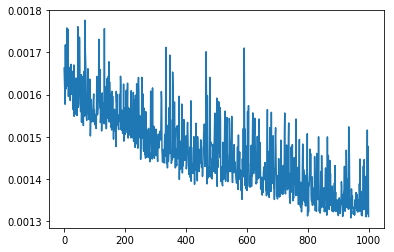

In [0]:
plt.plot(h.history['loss'])

### Predict Future 
* Use the last 12 monthes data of the train data set to predict the future 12 monthes production 
* Compare the predicted data with the real data in test data set

In [0]:
model = models.load_model('gdrive/My Drive/dataML/rnn_many_to_many_model.h5')

Get the last 12 monthes data of the train data

In [0]:
last_12_month_data = train_scaled[-12:].reshape([1,12])

In [0]:
predicts = model.predict(last_12_month_data).reshape([12,1])

In [0]:
results = scaler.inverse_transform(np.array(predicts).reshape(12,1))

In [0]:
test_set['Generated'] = results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
test_set

Milk Production   Generated
Month                                           
1975-01-01 01:00:00            834.0  849.133240
1975-02-01 01:00:00            782.0  799.488281
1975-03-01 01:00:00            892.0  901.998291
1975-04-01 01:00:00            903.0  912.084534
1975-05-01 01:00:00            966.0  967.772278
1975-06-01 01:00:00            937.0  939.251404
1975-07-01 01:00:00            896.0  898.477539
1975-08-01 01:00:00            858.0  854.013855
1975-09-01 01:00:00            817.0  802.374695
1975-10-01 01:00:00            827.0  797.896912
1975-11-01 01:00:00            797.0  760.601990
1975-12-01 01:00:00            843.0  801.358643

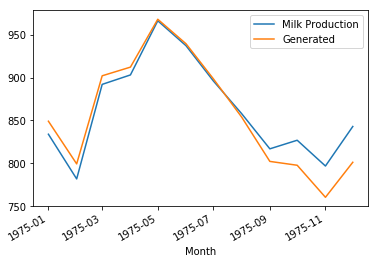

In [0]:
test_set.plot()

### Predict more 
Use the first months data to predict the future 13 years' milk productions and compare with the real data

In [0]:
train_seed = list(train_scaled[:12].flatten())

In [0]:
x_train = np.array(train_seed[-12:]).reshape(1,12)
one_predict = model.predict(x_train)

In [0]:
def get_prediction(data_list):
  train_seed = data_list
  for i in range(13):
    x_train = np.array(train_seed[-12:]).reshape(1,12)
    one_predict = model.predict(x_train)
    train_seed.extend(one_predict.flatten().tolist())
   
  return train_seed

In [0]:
train_seed = get_prediction(train_seed)

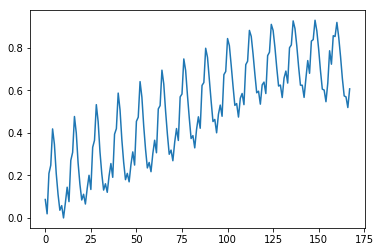

In [0]:
plt.plot(train_seed)

In [0]:
results = scaler.inverse_transform(np.array(train_seed).reshape(-1,1))

In [0]:
milk_predict = milk

In [0]:
milk_predict['Generated'] = results

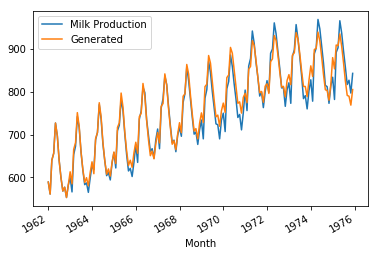

In [0]:
milk_predict.plot()